# Completion Trie and metrics

Evaluation of a completion system on wikpedia pages.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## Wikipedia titles, uniform

In [2]:
from mlstatpy.data.wikipedia import download_titles

file_titles = download_titles(country="fr")

In [3]:
from mlstatpy.data.wikipedia import enumerate_titles

list_titles = list(
    sorted(set(_ for _ in enumerate_titles(file_titles) if "A" <= _[0] <= "Z"))
)

In [4]:
len(list_titles), list_titles[:5], list_titles[1000000:1000005]

(3108490,
 ['A',
  'A & A',
  'A (Airport Express)',
  'A (Ayumi Hamasaki)',
  "A (Disque d'Ayumi Hamasaki)"],
 ['Fantasy in the sky',
  'Fantasy mythique',
  'Fantasy of manners',
  'Fantasy tennis',
  'Fantasy urbaine'])

In [5]:
from mlstatpy.nlp.completion import CompletionTrieNode


def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(w * len(q) for q, w in zip(queries, weights))
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0]) for p, w in per]
    wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keystroke2(w)[0]) for p, w in per]
    gain = sum(g * p / total for w, p, g in wks)
    gain_dyn = sum(g * p / total for w, p, g in wks_dyn)
    gain_dyn2 = sum(g * p / total for w, p, g in wks_dyn2)
    ave_length = sum(len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

In [6]:
import time, random, pandas


def benchmark(sizes):
    print("time", 0)
    allres = []
    for size in sizes:
        begin = time.perf_counter()
        if size is None:
            size = len(list_titles)
            spl = list_titles
        else:
            spl = random.sample(list_titles, size)
        spl.sort()
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.perf_counter() - begin
        print(
            "time: {0}s - nb={1}".format(dt, len(spl)),
            "gain",
            tuple(_ / res[-1] for _ in res),
        )
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]
    return df


df = benchmark([200, 500, 800, 1000, 2000, 5000, 8000, 10000, 20000])
df.tail(n=2)

time 0
time: 0.21504800644533353s - nb=200 gain (0.820872274143302, 0.820872274143302, 0.820872274143302, 1.0)
time: 0.6058446756721159s - nb=500 gain (0.7976588628762532, 0.7976588628762532, 0.7976588628762532, 1.0)
time: 1.009366944402156s - nb=800 gain (0.779308535065277, 0.779308535065277, 0.779308535065277, 1.0)
time: 1.2731077523609795s - nb=1000 gain (0.7819106501794998, 0.7819106501794998, 0.7819106501794998, 1.0)
time: 3.0382918326608044s - nb=2000 gain (0.7491075326810025, 0.7491075326810025, 0.7491075326810025, 1.0)
time: 6.941259884811901s - nb=5000 gain (0.7193327903836085, 0.7193534087277493, 0.7193534087277493, 1.0)
time: 12.096078319013222s - nb=8000 gain (0.6971821041145199, 0.6971821041145199, 0.6971821041145199, 1.0)
time: 17.030497306746902s - nb=10000 gain (0.6881011563817098, 0.6881371807341721, 0.6881371807341721, 1.0)
time: 30.55692095058407s - nb=20000 gain (0.6579791591697565, 0.6582343738435791, 0.6582343738435791, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
7,10000,17.030497,0.688101,0.688137,0.688137,1.0,0.688101,1.0,0.688137,1.000052,0.688137,1.000052
8,20000,30.556921,0.657979,0.658234,0.658234,1.0,0.657979,1.0,0.658234,1.000388,0.658234,1.000388


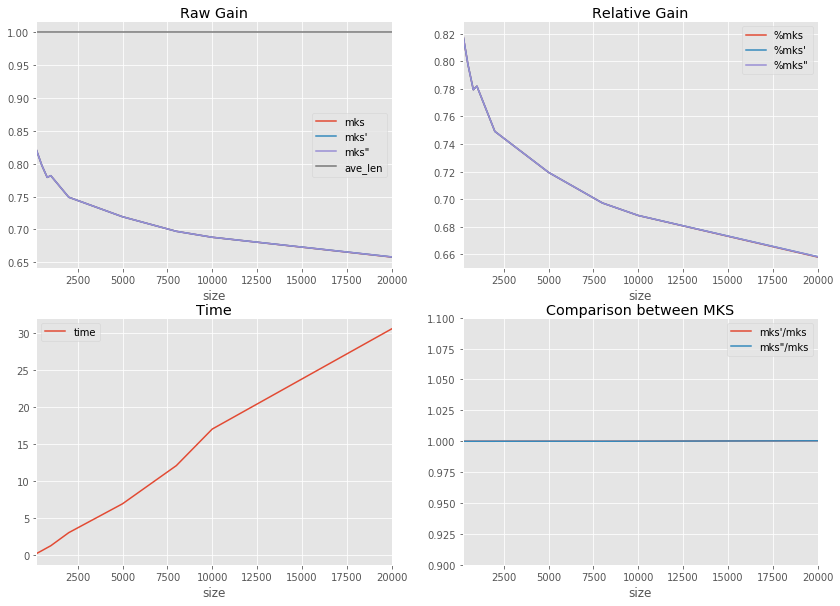

In [7]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(2, 2, figsize=(14, 10))
df.plot(x="size", y="time", ax=ax[1, 0])
df.plot(x="size", y=["mks", "mks'", 'mks"', "ave_len"], ax=ax[0, 0])
df.plot(x="size", y=["%mks", "%mks'", '%mks"'], ax=ax[0, 1])
df.plot(x="size", y=["mks'/mks", 'mks"/mks'], ax=ax[1, 1])
ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
ax[1, 1].set_ylim([0.9, 1.1])
ax[0, 0].set_title("Raw Gain")
ax[0, 1].set_title("Relative Gain")
ax[1, 0].set_title("Time")
ax[1, 1].set_title("Comparison between MKS")

## Reduce the alphabet size

In [8]:
from mlstatpy.data.wikipedia import enumerate_titles

list_titles = list(
    sorted(set(_ for _ in enumerate_titles(file_titles) if "A" <= _[0] <= "Z"))
)

In [9]:
import time, random, pandas


def char_modulo(c, size):
    if len(c) != 1:
        raise Exception("unexpected size '%s'" % c)
    # if len(c) != len(c.lower()):
    #    raise Exception("unexpected lower size '%s' != '%s' (%d != %d)" % (c, c.lower(), len(c), len(c.lower())))
    if size is None:
        return c
    else:
        cl = c.lower()
        if len(cl) > len(c):
            cl = c
        o = ord(cl)
        a = 97
        d = (o - a) + size * 10
        return chr(97 + (d % size))


def reduce_alphabet(sample, size):
    return ["".join(char_modulo(c, size) for c in word) for word in sample]


def benchmark_size(size, alphabet_sizes):
    if size is None:
        size = len(list_titles)
        sample = list_titles
    else:
        sample = random.sample(list_titles, size)
    print("time", 0)
    allres = []
    for size in alphabet_sizes:
        begin = time.perf_counter()
        spl = reduce_alphabet(sample, size)
        spl = list(sorted(set(spl)))
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.perf_counter() - begin
        print(
            "time: {0}s - nb={1}".format(dt, len(spl)),
            "gain",
            tuple(_ / res[-1] for _ in res),
        )
        if size is None:
            size = max(_ for _ in alphabet_sizes if _ is not None) + 5
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]
    return df


df = benchmark_size(5000, [None] + list(range(2, 26)))
df.tail(n=2)

time 0
time: 7.59344921135289s - nb=5000 gain (0.716585290640898, 0.716585290640898, 0.716585290640898, 1.0)
time: 3.8923985946166795s - nb=4581 gain (0.41594360086768417, 0.4448874994683378, 0.4448874994683378, 1.0)
time: 5.085379287694195s - nb=4942 gain (0.5571683533987387, 0.5620376961406324, 0.5620376961406324, 1.0)
time: 5.121866923020207s - nb=4974 gain (0.5983975448244626, 0.6052151883090817, 0.6052151883090817, 1.0)
time: 5.501076360438674s - nb=4991 gain (0.6380275314306908, 0.6382847383691052, 0.6382847383691052, 1.0)
time: 5.524899975880544s - nb=4988 gain (0.6475382003395598, 0.6479497864896859, 0.6479497864896859, 1.0)
time: 6.245833967660474s - nb=4997 gain (0.6639308855291576, 0.6639308855291576, 0.6639308855291576, 1.0)
time: 6.012760238038936s - nb=4997 gain (0.6712028636672216, 0.6712028636672216, 0.6712028636672216, 1.0)
time: 6.076252674864918s - nb=4997 gain (0.6838256469329845, 0.6839490681696653, 0.6839490681696653, 1.0)
time: 6.111897439143831s - nb=4999 gain (

,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
23,24,6.133951,0.712490,0.712490,0.712490,1.0,0.712490,1.0,0.712490,1.0,0.712490,1.0
24,25,6.292655,0.713611,0.713611,0.713611,1.0,0.713611,1.0,0.713611,1.0,0.713611,1.0


In [10]:
df = df.sort_values("size")

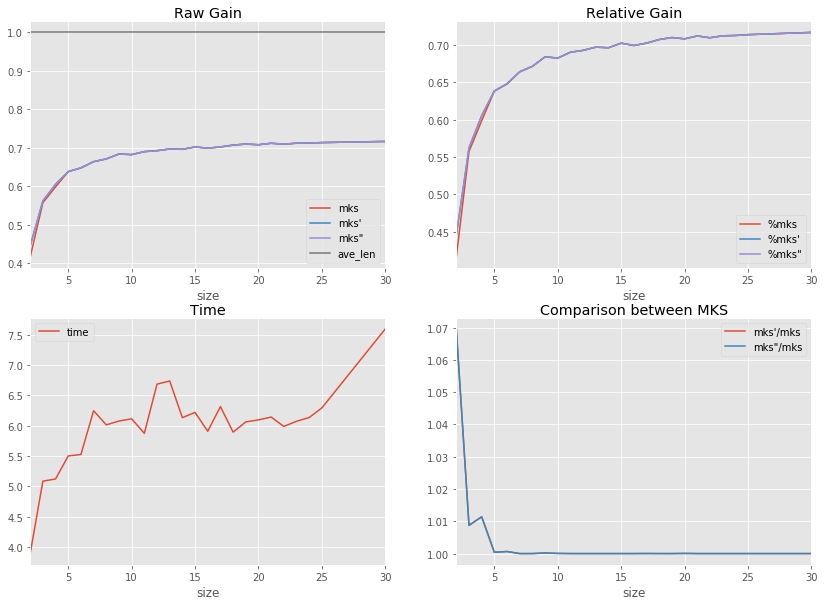

In [11]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(2, 2, figsize=(14, 10))
df.plot(x="size", y="time", ax=ax[1, 0])
df.plot(x="size", y=["mks", "mks'", 'mks"', "ave_len"], ax=ax[0, 0])
df.plot(x="size", y=["%mks", "%mks'", '%mks"'], ax=ax[0, 1])
df.plot(x="size", y=["mks'/mks", 'mks"/mks'], ax=ax[1, 1])
ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
# ax[1,1].set_ylim([0.9, 1.1])
ax[0, 0].set_title("Raw Gain")
ax[0, 1].set_title("Relative Gain")
ax[1, 0].set_title("Time")
ax[1, 1].set_title("Comparison between MKS")

## Wikipedia titles, uniform, longer test

In [12]:
df2 = benchmark([50000])
df2.tail(n=2)

time 0
time: 52.057980205573585s - nb=50000 gain (0.6162242515637921, 0.616305075104518, 0.616305075104518, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
0,50000,52.05798,0.616224,0.616305,0.616305,1.0,0.616224,1.0,0.616305,1.000131,0.616305,1.000131


In [13]:
df2 = benchmark(
    [50000, 100000, 200000]
)  # , 500000, 500000, 1000000, 2000000, None]) too long in python
df2.tail(n=2)

time 0
time: 52.51158252780897s - nb=50000 gain (0.615225173328998, 0.6153599275825006, 0.6153599275825006, 1.0)
time: 105.0721302614229s - nb=100000 gain (0.5836043296652512, 0.5841384772496148, 0.5841384772496148, 1.0)
time: 187.86111486480695s - nb=200000 gain (0.5507786166438062, 0.5518801462043321, 0.5518801462043321, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
1,100000,105.072130,0.583604,0.584138,0.584138,1.0,0.583604,1.0,0.584138,1.000915,0.584138,1.000915
2,200000,187.861115,0.550779,0.551880,0.551880,1.0,0.550779,1.0,0.551880,1.002000,0.551880,1.002000


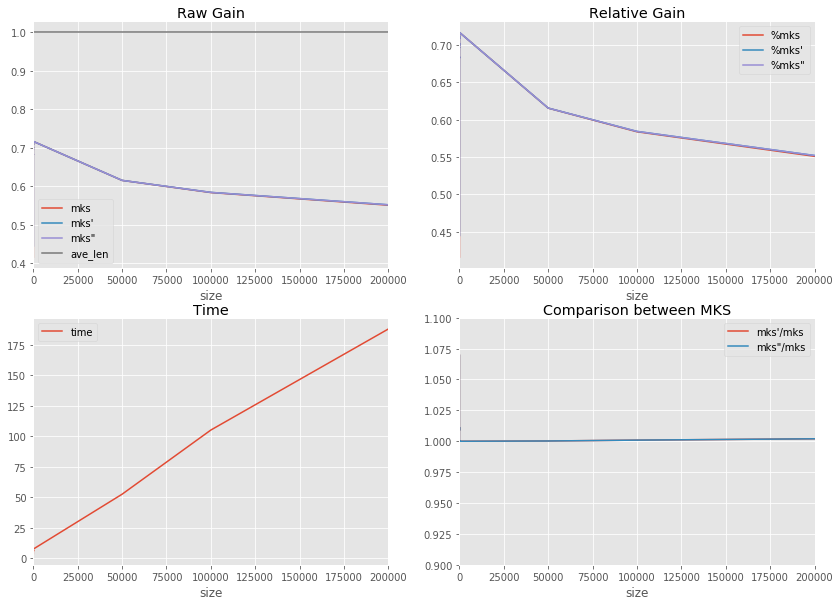

In [14]:
dfall = pandas.concat([df, df2])
f, ax = plt.subplots(2, 2, figsize=(14, 10))
dfall.plot(x="size", y="time", ax=ax[1, 0])
dfall.plot(x="size", y=["mks", "mks'", 'mks"', "ave_len"], ax=ax[0, 0])
dfall.plot(x="size", y=["%mks", "%mks'", '%mks"'], ax=ax[0, 1])
dfall.plot(x="size", y=["mks'/mks", 'mks"/mks'], ax=ax[1, 1])
ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
ax[1, 1].set_ylim([0.9, 1.1])
ax[0, 0].set_title("Raw Gain")
ax[0, 1].set_title("Relative Gain")
ax[1, 0].set_title("Time")
ax[1, 1].set_title("Comparison between MKS")